# Practice with Spatial Data and Geopandas
### Alex
This notebook is meant to be extra practice with plotting spatial data using `matplotlib` and `geopandas`. You will be required to:
- convert a `.csv` file to a `GeoDataFrame`
- use `dissolve` on a `GeoDataFrame`
- work with figures and axes to plot layers
- join two datasets together using `.merge`
- do a spatial join and plot based on the joined column


In [2]:
from vega_datasets import data # dataset library
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
# datasets
quakes = gpd.read_file(data.earthquakes.url)
quakes = quakes.loc[:, ['mag', 'geometry']]
obesity = pd.read_json(data.obesity.url)
airports = pd.read_csv(data.airports.url)
countries = gpd.read_file('data/countries.geojson')
county_map = gpd.read_file('data/usa_map.geojson')
fips_codes = pd.read_csv('data/us-state-ansi-fips.csv', sep=', ')

In [4]:
# Dissolve
county_map = county_map.drop(['AFFGEOID', 'GEOID', 'NAME', 'COUNTYFP'], axis=1)
state_map = county_map.dissolve(by='STATEFP').reset_index()
state_map['STATEFP'] = state_map['STATEFP'].astype(int)
state_map = state_map.merge(fips_codes, left_on='STATEFP', right_on='st')

# Problem 1) World Earthquake Plot
### Alex
Plot the `earthquakes` dataset (stored in the variable `quakes`) on a map of the world. The background countries should be color `gray` and the earhthquakes should be plotted as orange points, where each point has a `markersize` corresponding to the magnitude of the earthquake squared. Your plot should look something like this:  
  
![World Quakes](spatial_viz_img/world_quakes.png)

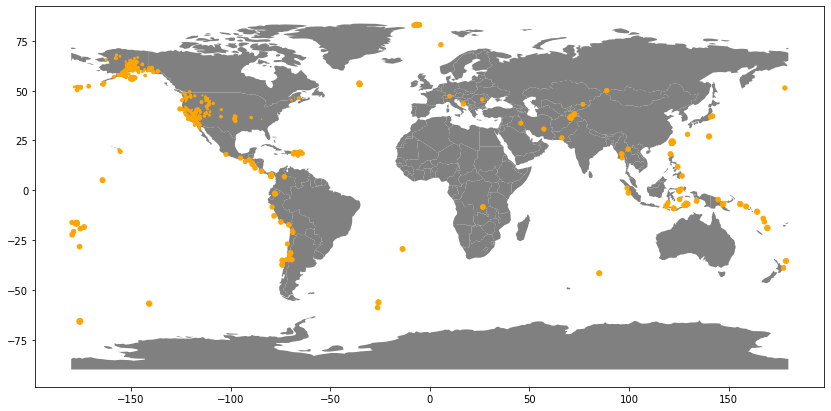

In [5]:
fig, ax = plt.subplots(1, figsize=(15, 7))
countries.plot(ax=ax, color='gray')
quakes.plot(markersize=quakes['mag'] ** 2, ax=ax, color='orange')
fig.savefig('spatial_viz_img/world_quakes.png', bbox_inches='tight')

# Problem 2: Joined Chloropleth Plot
### Alex
Plot the lower 48 states of the USA, colored by the obesity rate. This will require you to join the `state_map` dataset with the `obesity` dataset and then drop Hawaii and Alaska from the result. As a note, `.merge` returns whatever type the function is originally called on.  
  
For example, if we have a `GeoDataFrame` called `gdf` and a `DataFrame` called `df`, and I call `gdf.merge(df)`, the return type will be `GeoDataFrame`. However, if I call `df.merge(gdf)`, the return type will be `DataFrame`. Keep this in mind when joining the two datasets. Your result should look something like this: 
  
![Obesity Chloropleth](spatial_viz_img/obesity_rate_chloropleth.png)

In [ ]:
joined_gdf = state_map.merge(obesity, left_on='stusps', right_on='state')\
    .drop([1, 10])
joined_gdf.plot(column='rate', legend=True,figsize=(15, 7))
plt.show()

# Problem 3) CSV to `GeoDataFrame`
### Alex
This problem is practice for converting a .csv file to a `GeoDataFrame` using the `zip` function. Given the `airports` dataset as a `DataFrame`, create a `GeoDataFrame` and store it in an `airports_gdf` variable. Then use `.sjoin` to plot the lower 48 states and only those airports that appear in those states. Plot the background as 'lightgray', give the airports a `markersize` of 3, and be sure to drop Alaska and Hawaii. Your plot should look something like this:  
  
![Airport Plot](spatial_viz_img/airports_lower_48.png)

In [6]:
from shapely.geometry import Point
airports['geometry'] = [Point(long, lat) for long, lat in 
                           zip(airports['longitude'], airports['latitude'])]
airports_gdf = gpd.GeoDataFrame(airports, geometry='geometry')
lower_48 = state_map.drop([1, 11])
airports_in_lower_48 = gpd.sjoin(airports_gdf, lower_48, how='inner', op='intersects')
fig, ax = plt.subplots(1, figsize=(15, 7))
lower_48.plot(ax=ax, color='lightgray')
airports_in_lower_48.plot(ax=ax, color='steelblue', markersize=3)
fig.savefig('spatial_viz_img/airports_lower_48.png', bbox_inches='tight')


# Challenge Problem) Centroid Map
### Alex
Using the `airports` dataset, plot a centroid map of the airports in the lower 48 United States. Do this by plotting points that are the average of the latitude and longitude of airports in a given state, but have size correlated to the total number of airports in that state. Your plot should look something like this:  
  
![Centroid Map](spatial_viz_img/airports_centroid.png)

In [8]:
airports_centroid_base = airports[['state', 'latitude', 'longitude']]
airports_count_by_state = airports_centroid_base.groupby('state').count()
airports_count_by_state = airports_count_by_state.rename(columns={'latitude': 'count'})\
    .drop(['longitude'], axis=1)\
    .reset_index()
airports_location_average = airports_centroid_base.groupby('state')\
    .mean()\
    .reset_index()
airports_centroid = airports_location_average.merge(airports_count_by_state, on='state')
airports_centroid = gpd.GeoDataFrame(airports_centroid, geometry=[Point(lon, lat)\
    for lat, lon in zip(airports_centroid['latitude'], airports_centroid['longitude'])])

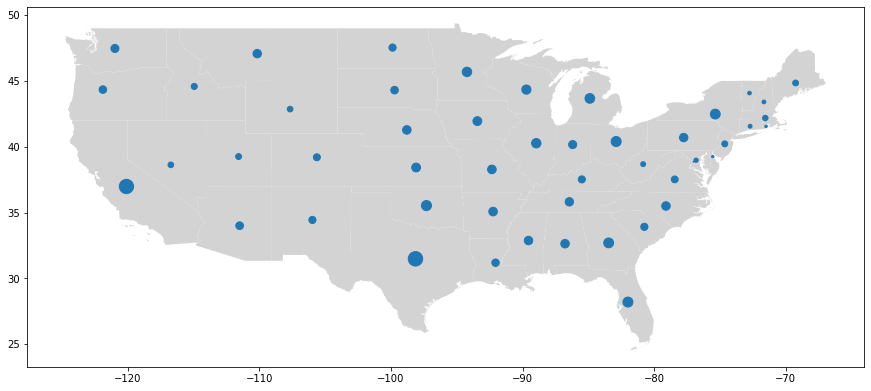

In [9]:
fig, ax = plt.subplots(1, figsize=(15, 7))
airports_centroid_lower_48 = gpd.sjoin(airports_centroid, lower_48, how='inner')
lower_48.plot(ax=ax, color='lightgray')
airports_centroid_lower_48.plot(ax=ax, markersize=airports_centroid_lower_48['count'])
fig.savefig('spatial_viz_img/airports_centroid.png', bbox_inches='tight')